In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import copy
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from scipy.stats import spearmanr, rankdata
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import time
import _pickle as cp
import sys
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from astropy.stats import median_absolute_deviation

# Loading Dataframe & splitting

In [2]:
combined = pd.read_csv('combined.csv', index_col='Unnamed: 0')
combined.head()

,Store,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,8.130240e+16,5263,555,1,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,8.130240e+16,6064,625,1,1,0,1,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,8.130240e+16,8314,821,1,1,0,1,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4,8.130240e+16,13995,1498,1,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,8.130240e+16,4822,559,1,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
labels = combined['Sales'].to_numpy().reshape(-1, 1)
features = combined.drop(columns=['Sales'])

# IGTD codebase


In [4]:
# @title select_features_by_variation
def select_features_by_variation(data, variation_measure='var', threshold=None, num=None, draw_histogram=False,
                                 bins=100, log=False):
    '''
    This function evaluates the variations of individual features and returns the indices of features with large
    variations. Missing values are ignored in evaluating variation.

    Parameters:
    -----------
    data: numpy array or pandas data frame of numeric values, with a shape of [n_samples, n_features].
    variation_metric: string indicating the metric used for evaluating feature variation. 'var' indicates variance;
        'std' indicates standard deviation; 'mad' indicates median absolute deviation. Default is 'var'.
    threshold: float. Features with a variation larger than threshold will be selected. Default is None.
    num: positive integer. It is the number of features to be selected based on variation.
        The number of selected features will be the smaller of num and the total number of
        features with non-missing variations. Default is None. threshold and portion can not take values
        and be used simultaneously.
    draw_histogram: boolean, whether to draw a histogram of feature variations. Default is False.
    bins: positive integer, the number of bins in the histogram. Default is the smaller of 50 and the number of
        features with non-missing variations.
    log: boolean, indicating whether the histogram should be drawn on log scale.


    Returns:
    --------
    indices: 1-D numpy array containing the indices of selected features. If both threshold and
        portion are None, indices will be an empty array.
    '''

    if isinstance(data, pd.DataFrame):
        data = data.values
    elif not isinstance(data, np.ndarray):
        print('Input data must be a numpy array or pandas data frame')
        sys.exit(1)

    if variation_measure == 'std':
        v_all = np.nanstd(a=data, axis=0)
    elif variation_measure == 'mad':
        v_all = median_absolute_deviation(data=data, axis=0, ignore_nan=True)
    else:
        v_all = np.nanvar(a=data, axis=0)

    indices = np.where(np.invert(np.isnan(v_all)))[0]
    v = v_all[indices]

    if draw_histogram:
        if len(v) < 50:
            print('There must be at least 50 features with variation measures to draw a histogram')
        else:
            bins = int(min(bins, len(v)))
            _ = plt.hist(v, bins=bins, log=log)
            plt.show()

    if threshold is None and num is None:
        return np.array([])
    elif threshold is not None and num is not None:
        print('threshold and portion can not be used simultaneously. Only one of them can take a real value')
        sys.exit(1)

    if threshold is not None:
        indices = indices[np.where(v > threshold)[0]]
    else:
        n_f = int(min(num, len(v)))
        indices = indices[np.argsort(-v)[:n_f]]

    indices = np.sort(indices)

    return indices


In [5]:
# @title min_max_transform
def min_max_transform(data):
    '''
    This function does a linear transformation of each feature, so that the minimum and maximum values of a
    feature are 0 and 1, respectively.

    Input:
    data: an input data array with a size of [n_sample, n_feature]
    Return:
    norm_data: the data array after transformation
    '''

    norm_data = np.empty(data.shape)
    norm_data.fill(np.nan)
    for i in range(data.shape[1]):
        v = data[:, i].copy()
        if np.max(v) == np.min(v):
            norm_data[:, i] = 0
        else:
            v = (v - np.min(v)) / (np.max(v) - np.min(v))
            norm_data[:, i] = v
    return norm_data

In [6]:
# @title generate_feature_distance_ranking
def generate_feature_distance_ranking(data, method='Pearson'):
    '''
    This function generates ranking of distances/dissimilarities between features for tabular data.

    Input:
    data: input data, n_sample by n_feature
    method: 'Euclidean' calculates similarity between features based on Euclidean distance;
        'Pearson' uses Pearson correlation coefficient to evaluate similarity between features;
        'Spearman' uses Spearman correlation coefficient to evaluate similarity between features;
        'set' uses Jaccard index to evaluate similarity between features that are binary variables.

    Return:
    ranking: symmetric ranking matrix based on dissimilarity
    corr: matrix of distances between features
    '''

    num = data.shape[1]
    if method == 'Pearson':
        corr = np.corrcoef(np.transpose(data))
    elif method == 'Spearman':
        corr = spearmanr(data).correlation
    elif method == 'Euclidean':
        corr = squareform(pdist(np.transpose(data), metric='euclidean'))
        corr = np.max(corr) - corr
        corr = corr / np.max(corr)
    elif method == 'set':  # This is the new set operation to calculate similarity. It does not tolerate all-zero features.
        corr1 = np.dot(np.transpose(data), data)
        corr2 = data.shape[0] - np.dot(np.transpose(1 - data), 1 - data)
        corr = corr1 / corr2

    corr = 1 - corr
    corr = np.around(a=corr, decimals=10)

    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(corr[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    return ranking, corr

In [7]:
# @title generate_matrix_distance_ranking
def generate_matrix_distance_ranking(num_r, num_c, method='Euclidean', num=None):
    '''
    This function calculates the ranking of distances between all pairs of entries in a matrix of size num_r by num_c.

    Input:
    num_r: number of rows in the matrix
    num_c: number of columns in the matrix
    method: method used to calculate distance. Can be 'Euclidean' or 'Manhattan'.
    num: number of real features. If None, num = num_r * num_c. If num < num_r * num_c, num_r * num_c - num
        zeros will be padded to the image representation.

    Return:
    coordinate: a num-by-2 matrix giving the coordinates of elements in the matrix.
    ranking: a num-by-num matrix giving the ranking of pair-wise distance.

    '''

    if num is None:
        num = num_r * num_c

    # generate the coordinates of elements in a matrix
    for r in range(num_r):
        if r == 0:
            coordinate = np.transpose(np.vstack((np.zeros(num_c), range(num_c))))
        else:
            coordinate = np.vstack((coordinate, np.transpose(np.vstack((np.ones(num_c) * r, range(num_c))))))
    coordinate = coordinate[:num, :]

    # calculate the closeness of the elements
    cord_dist = np.zeros((num, num))
    if method == 'Euclidean':
        for i in range(num):
            cord_dist[i, :] = np.sqrt(np.square(coordinate[i, 0] * np.ones(num) - coordinate[:, 0]) +
                                     np.square(coordinate[i, 1] * np.ones(num) - coordinate[:, 1]))
    elif method == 'Manhattan':
        for i in range(num):
            cord_dist[i, :] = np.abs(coordinate[i, 0] * np.ones(num) - coordinate[:, 0]) + \
                             np.abs(coordinate[i, 1] * np.ones(num) - coordinate[:, 1])

    # generate the ranking based on distance
    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(cord_dist[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    coordinate = np.int64(coordinate)
    return (coordinate[:, 0], coordinate[:, 1]), ranking

In [8]:
# @title IGTD_absolute_error
def IGTD_absolute_error(source, target, max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
                        save_folder=None, file_name=''):
    '''
    This function switches the order of rows (columns) in the source ranking matrix to make it similar to the target
    ranking matrix. In each step, the algorithm randomly picks a row that has not been switched with others for
    the longest time and checks all possible switch of this row, and selects the switch that reduces the
    dissimilarity most. Dissimilarity (i.e. the error) is the summation of absolute difference of
    lower triangular elements between the rearranged source ranking matrix and the target ranking matrix.

    Input:
    source: a symmetric ranking matrix with zero diagonal elements.
    target: a symmetric ranking matrix with zero diagonal elements. 'source' and 'target' should have the same size.
    max_step: the maximum steps that the algorithm should run if never converges.
    switch_t: the threshold to determine whether feature switching should happen
    val_step: number of steps for checking gain on the objective function to determine convergence
    min_gain: if the objective function is not improved more than 'min_gain' in 'val_step' steps,
        the algorithm terminates.
    random_state: for setting random seed.
    save_folder: a path to save the picture of source ranking matrix in the optimization process.
    file_name: a string as part of the file names for saving results

    Return:
    index_record: indices to rearrange the rows(columns) in source obtained the optimization process
    err_record: error obtained in the optimization process
    run_time: the time at which each step is completed in the optimization process
    '''

    np.random.RandomState(seed=random_state)
    if os.path.exists(save_folder):
        shutil.rmtree(save_folder)
    os.mkdir(save_folder)

    source = source.copy()
    num = source.shape[0]
    tril_id = np.tril_indices(num, k=-1)
    index = np.array(range(num))
    index_record = np.empty((max_step + 1, num))
    index_record.fill(np.nan)
    index_record[0, :] = index.copy()

    # calculate the error associated with each row
    err_v = np.empty(num)
    err_v.fill(np.nan)
    for i in range(num):
        err_v[i] = np.sum(np.abs(source[i, 0:i] - target[i, 0:i])) + \
                   np.sum(np.abs(source[(i + 1):, i] - target[(i + 1):, i]))

    step_record = -np.ones(num)
    err_record = [np.sum(abs(source[tril_id] - target[tril_id]))]
    pre_err = err_record[0]
    t1 = time.time()
    run_time = [0]

    for s in range(max_step):
        delta = - np.ones(num) * np.inf

        # randomly pick a row that has not been considered for the longest time
        idr = np.where(step_record == np.min(step_record))[0]
        ii = idr[np.random.permutation(len(idr))[0]]

        for jj in range(num):
            if jj == ii:
                continue

            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii

            err_ori = err_v[i] + err_v[j] - np.abs(source[j, i] - target[j, i])

            err_i = np.sum(np.abs(source[j, :i] - target[i, :i])) + \
                    np.sum(np.abs(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                    np.sum(np.abs(source[(j + 1):, j] - target[(j + 1):, i])) + np.abs(source[i, j] - target[j, i])
            err_j = np.sum(np.abs(source[i, :i] - target[j, :i])) + \
                    np.sum(np.abs(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                    np.sum(np.abs(source[(j + 1):, i] - target[(j + 1):, j])) + np.abs(source[i, j] - target[j, i])
            err_test = err_i + err_j - np.abs(source[i, j] - target[j, i])

            delta[jj] = err_ori - err_test

        delta_norm = delta / pre_err
        id = np.where(delta_norm >= switch_t)[0]
        if len(id) > 0:
            jj = np.argmax(delta)

            # Update the error associated with each row
            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii
            for k in range(num):
                if k < i:
                    err_v[k] = err_v[k] - np.abs(source[i, k] - target[i, k]) - np.abs(source[j, k] - target[j, k]) + \
                               np.abs(source[j, k] - target[i, k]) + np.abs(source[i, k] - target[j, k])
                elif k == i:
                    err_v[k] = np.sum(np.abs(source[j, :i] - target[i, :i])) + \
                    np.sum(np.abs(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                    np.sum(np.abs(source[(j + 1):, j] - target[(j + 1):, i])) + np.abs(source[i, j] - target[j, i])
                elif k < j:
                    err_v[k] = err_v[k] - np.abs(source[k, i] - target[k, i]) - np.abs(source[j, k] - target[j, k]) + \
                               np.abs(source[k, j] - target[k, i]) + np.abs(source[i, k] - target[j, k])
                elif k == j:
                    err_v[k] = np.sum(np.abs(source[i, :i] - target[j, :i])) + \
                    np.sum(np.abs(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                    np.sum(np.abs(source[(j + 1):, i] - target[(j + 1):, j])) + np.abs(source[i, j] - target[j, i])
                else:
                    err_v[k] = err_v[k] - np.abs(source[k, i] - target[k, i]) - np.abs(source[k, j] - target[k, j]) + \
                               np.abs(source[k, j] - target[k, i]) + np.abs(source[k, i] - target[k, j])

            # switch rows i and j
            ii_v = source[ii, :].copy()
            jj_v = source[jj, :].copy()
            source[ii, :] = jj_v
            source[jj, :] = ii_v
            ii_v = source[:, ii].copy()
            jj_v = source[:, jj].copy()
            source[:, ii] = jj_v
            source[:, jj] = ii_v
            err = pre_err - delta[jj]

            # update rearrange index
            t = index[ii]
            index[ii] = index[jj]
            index[jj] = t

            # update step record
            step_record[ii] = s
            step_record[jj] = s
        else:
            # error is not changed due to no switch
            err = pre_err

            # update step record
            step_record[ii] = s

        err_record.append(err)
        print('Step ' + str(s) + ' err: ' + str(err))
        index_record[s + 1, :] = index.copy()
        run_time.append(time.time() - t1)

        if s > val_step:
            if np.sum((err_record[-val_step - 1] - np.array(err_record[(-val_step):])) / err_record[
                -val_step - 1] >= min_gain) == 0:
                break

        pre_err = err

    index_record = index_record[:len(err_record), :].astype(int)
    if save_folder is not None:
        pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
            sep='\t', lineterminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
            columns=['error', 'steps']).to_csv(save_folder + '/' + file_name + '_error_and_step.txt',
            header=True, index=False, sep='\t', lineterminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
            save_folder + '/' + file_name + '_error_and_time.txt', header=True, index=False, sep='\t',
            lineterminator='\r\n')

    return index_record, err_record, run_time

In [9]:
# @title IGTD_square_error
def IGTD_square_error(source, target, max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
                      save_folder=None, file_name=''):
    '''
    This function switches the order of rows (columns) in the source ranking matrix to make it similar to the target
    ranking matrix. In each step, the algorithm randomly picks a row that has not been switched with others for
    the longest time and checks all possible switch of this row, and selects the switch that reduces the
    dissimilarity most. Dissimilarity (i.e. the error) is the summation of squared difference of
    lower triangular elements between the rearranged source ranking matrix and the target ranking matrix.

    Input:
    source: a symmetric ranking matrix with zero diagonal elements.
    target: a symmetric ranking matrix with zero diagonal elements. 'source' and 'target' should have the same size.
    max_step: the maximum steps that the algorithm should run if never converges.
    switch_t: the threshold to determine whether feature switching should happen
    val_step: number of steps for checking gain on the objective function to determine convergence
    min_gain: if the objective function is not improved more than 'min_gain' in 'val_step' steps,
        the algorithm terminates.
    random_state: for setting random seed.
    save_folder: a path to save the picture of source ranking matrix in the optimization process.
    file_name: a string as part of the file names for saving results

    Return:
    index_record: ordering index to rearrange the rows(columns) in 'source' in the optimization process
    err_record: the error history in the optimization process
    run_time: the time at which each step is finished in the optimization process
    '''


    np.random.RandomState(seed=random_state)
    if os.path.exists(save_folder):
        shutil.rmtree(save_folder)
    os.mkdir(save_folder)

    source = source.copy()
    num = source.shape[0]
    tril_id = np.tril_indices(num, k=-1)
    index = np.array(range(num))
    index_record = np.empty((max_step + 1, num))
    index_record.fill(np.nan)
    index_record[0, :] = index.copy()

    # calculate the error associated with each row
    err_v = np.empty(num)
    err_v.fill(np.nan)
    for i in range(num):
        err_v[i] = np.sum(np.square(source[i, 0:i] - target[i, 0:i])) + \
                   np.sum(np.square(source[(i + 1):, i] - target[(i + 1):, i]))

    step_record = -np.ones(num)
    err_record = [np.sum(np.square(source[tril_id] - target[tril_id]))]
    pre_err = err_record[0]
    t1 = time.time()
    run_time = [0]

    for s in range(max_step):
        delta = - np.ones(num) * np.inf

        # randomly pick a row that has not been considered for the longest time
        idr = np.where(step_record == np.min(step_record))[0]
        ii = idr[np.random.permutation(len(idr))[0]]

        for jj in range(num):
            if jj == ii:
                continue

            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii

            err_ori = err_v[i] + err_v[j] - np.square(source[j, i] - target[j, i])

            err_i = np.sum(np.square(source[j, :i] - target[i, :i])) + \
                    np.sum(np.square(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                    np.sum(np.square(source[(j + 1):, j] - target[(j + 1):, i])) + np.square(source[i, j] - target[j, i])
            err_j = np.sum(np.square(source[i, :i] - target[j, :i])) + \
                    np.sum(np.square(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                    np.sum(np.square(source[(j + 1):, i] - target[(j + 1):, j])) + np.square(source[i, j] - target[j, i])
            err_test = err_i + err_j - np.square(source[i, j] - target[j, i])

            delta[jj] = err_ori - err_test

        delta_norm = delta / pre_err
        id = np.where(delta_norm >= switch_t)[0]
        if len(id) > 0:
            jj = np.argmax(delta)

            # Update the error associated with each row
            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii
            for k in range(num):
                if k < i:
                    err_v[k] = err_v[k] - np.square(source[i, k] - target[i, k]) - np.square(source[j, k] - target[j, k]) + \
                               np.square(source[j, k] - target[i, k]) + np.square(source[i, k] - target[j, k])
                elif k == i:
                    err_v[k] = np.sum(np.square(source[j, :i] - target[i, :i])) + \
                        np.sum(np.square(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                        np.sum(np.square(source[(j + 1):, j] - target[(j + 1):, i])) + np.square(source[i, j] - target[j, i])
                elif k < j:
                    err_v[k] = err_v[k] - np.square(source[k, i] - target[k, i]) - np.square(source[j, k] - target[j, k]) + \
                               np.square(source[k, j] - target[k, i]) + np.square(source[i, k] - target[j, k])
                elif k == j:
                    err_v[k] = np.sum(np.square(source[i, :i] - target[j, :i])) + \
                        np.sum(np.square(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                        np.sum(np.square(source[(j + 1):, i] - target[(j + 1):, j])) + np.square(source[i, j] - target[j, i])
                else:
                    err_v[k] = err_v[k] - np.square(source[k, i] - target[k, i]) - np.square(source[k, j] - target[k, j]) + \
                               np.square(source[k, j] - target[k, i]) + np.square(source[k, i] - target[k, j])

            # switch rows i and j
            ii_v = source[ii, :].copy()
            jj_v = source[jj, :].copy()
            source[ii, :] = jj_v
            source[jj, :] = ii_v
            ii_v = source[:, ii].copy()
            jj_v = source[:, jj].copy()
            source[:, ii] = jj_v
            source[:, jj] = ii_v
            err = pre_err - delta[jj]

            # update rearrange index
            t = index[ii]
            index[ii] = index[jj]
            index[jj] = t

            # update step record
            step_record[ii] = s
            step_record[jj] = s
        else:
            # error is not changed due to no switch
            err = pre_err

            # update step record
            step_record[ii] = s

        err_record.append(err)
        print('Step ' + str(s) + ' err: ' + str(err))
        index_record[s + 1, :] = index.copy()
        run_time.append(time.time() - t1)

        if s > val_step:
            if np.sum((err_record[-val_step - 1] - np.array(err_record[(-val_step):])) / err_record[
                -val_step - 1] >= min_gain) == 0:
                break

        pre_err = err

    index_record = index_record[:len(err_record), :].astype(int)
    if save_folder is not None:
        pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
            sep='\t', lineterminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
            columns=['error', 'steps']).to_csv(save_folder + '/' + file_name + '_error_and_step.txt',
            header=True, index=False, sep='\t', lineterminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
            save_folder + '/' + file_name + '_error_and_time.txt', header=True, index=False, sep='\t',
            lineterminator='\r\n')

    return index_record, err_record, run_time

In [10]:
# @title IGTD
def IGTD(source, target, err_measure='abs', max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
         save_folder=None, file_name=''):
    '''
    This is just a wrapper function that wraps the two search functions using different error measures.
    '''

    if err_measure == 'abs':
        index_record, err_record, run_time = IGTD_absolute_error(source=source,
            target=target, max_step=max_step, switch_t=switch_t, val_step=val_step, min_gain=min_gain,
            random_state=random_state, save_folder=save_folder, file_name=file_name)
    if err_measure == 'squared':
        index_record, err_record, run_time = IGTD_square_error(source=source,
            target=target, max_step=max_step, switch_t=switch_t, val_step=val_step, min_gain=min_gain,
            random_state=random_state, save_folder=save_folder, file_name=file_name)

    return index_record, err_record, run_time

In [11]:
# @title generate_image_data
def generate_image_data(data, index, num_row, num_column, coord, image_folder=None, file_name=''):
    '''
    This function generates the data in image format according to rearrangement indices. It saves the data
    sample-by-sample in both txt files and image files

    Input:
    data: original tabular data, 2D array or data frame, n_samples by n_features
    index: indices of features obtained through optimization, according to which the features can be
        arranged into a num_r by num_c image.
    num_row: number of rows in image
    num_column: number of columns in image
    coord: coordinates of features in the image/matrix
    image_folder: directory to save the image and txt data files. If none, no data file is saved
    file_name: a string as a part of the file names to save data

    Return:
    image_data: the generated data, a 3D numpy array. The third dimension is across samples. The range of values
        is [0, 255]. Small values actually indicate high values in the original data.
    samples: the names of indices of the samples
    '''

    if isinstance(data, pd.DataFrame):
        samples = data.index.map(np.str)
        data = data.values
    else:
        samples = [str(i) for i in range(data.shape[0])]

    if os.path.exists(image_folder):
        shutil.rmtree(image_folder)
    os.mkdir(image_folder)

    data_2 = data.copy()
    data_2 = data_2[:, index]
    max_v = np.max(data_2)
    min_v = np.min(data_2)
    data_2 = 255 - (data_2 - min_v) / (max_v - min_v) * 255 # Black color in heatmap indicates high value

    image_data = np.empty((num_row, num_column, data_2.shape[0]))
    image_data.fill(np.nan)
    for i in range(data_2.shape[0]):
        data_i = np.empty((num_row, num_column))
        data_i.fill(np.nan)
        data_i[coord] = data_2[i, :]

        # find nan in data_i and change them to 255
        idd = np.where(np.isnan(data_i))
        data_i[idd] = 255

        image_data[:, :, i] = data_i
        image_data[:, :, i] = 255 - image_data[:, :, i] # High values in the array format of image data correspond
                                                        # to high values in tabular data
        # Commented out by Moi, dont need it
        # if image_folder is not None:
        #     fig = plt.figure()
        #     plt.imshow(data_i, cmap='gray', vmin=0, vmax=255)
        #     plt.axis('scaled')
        #     plt.savefig(fname=image_folder + '/' + file_name + '_' + samples[i] + '_image.png', bbox_inches='tight',
        #                 pad_inches=0)
        #     plt.close(fig)

        #     pd.DataFrame(image_data[:, :, i], index=None, columns=None).to_csv(image_folder + '/' + file_name + '_'
        #         + samples[i] + '_data.txt', header=None, index=None, sep='\t', line_terminator='\r\n')

    return image_data, samples

In [12]:
# @title table_to_image
def table_to_image(norm_d, scale, fea_dist_method, image_dist_method, save_image_size, max_step, val_step, normDir,
                   error, switch_t=0, min_gain=0.00001):
    '''
    This function converts tabular data into images using the IGTD algorithm.

    Input:
    norm_d: a 2D array or data frame, which is the tabular data. Its size is n_samples by n_features
    scale: a list of two positive integers. It includes the numbers of pixel rows and columns in the image
        representation. The total number of pixels should not be smaller than the number of features,
        i.e. scale[0] * scale[1] >= n_features.
    fea_dist_method: a string indicating the method used for calculating the pairwise distances between features,
        for which there are three options.
        'Pearson' uses the Pearson correlation coefficient to evaluate the similarity between features.
        'Spearman' uses the Spearman correlation coefficient to evaluate the similarity between features.
        'set' uses the Jaccard index to evaluate the similarity between features that are binary variables.
    image_dist_method: a string indicating the method used for calculating the distances between pixels in image.
        It can be either 'Euclidean' or 'Manhattan'.
    save_image_size: size of images (in inches) for saving visual results.
    max_step: the maximum number of iterations that the IGTD algorithm will run if never converges.
    val_step: the number of iterations for determining algorithm convergence. If the error reduction rate is smaller than
        min_gain for val_step iterations, the algorithm converges.
    normDir: a string indicating the directory to save result files.
    error: a string indicating the function to evaluate the difference between feature distance ranking and pixel
        distance ranking. 'abs' indicates the absolute function. 'squared' indicates the square function.
    switch_t: the threshold on error change rate. Error change rate is
        (error before feature swapping - error after feature swapping) / error before feature swapping.
        In each iteration, if the largest error change rate resulted from all possible feature swappings
        is not smaller than switch_t, the feature swapping resulting in the largest error change rate will
        be performed. If switch_t >= 0, the IGTD algorithm monotonically reduces the error during optimization.
    min_gain: if the error reduction rate is not larger than min_gain for val_step iterations, the algorithm converges.

    Return:
    This function does not return any variable, but saves multiple result files, which are the following
    1.  Results.pkl stores the original tabular data, the generated image data, and the names of samples. The generated
        image data is a 3D numpy array. Its size is [number of pixel rows in image, number of pixel columns in image,
        number of samples]. The range of values is [0, 255]. Small values in the array actually correspond to high
        values in the tabular data.
    2.  Results_Auxiliary.pkl stores the ranking matrix of pairwise feature distances before optimization,
        the ranking matrix of pairwise pixel distances, the coordinates of pixels when concatenating pixels
        row by row from image to form the pixel distance ranking matrix, error in each iteration,
        and time (in seconds) when completing each iteration.
    3.  original_feature_ranking.png shows the feature distance ranking matrix before optimization.
    4.  image_ranking.png shows the pixel distance ranking matrix.
    5.  error_and_runtime.png shows the change of error vs. time during the optimization process.
    6.  error_and_iteration.png shows the change of error vs. iteration during the optimization process.
    7.  optimized_feature_ranking.png shows the feature distance ranking matrix after optimization.
    8.  data folder includes two image data files for each sample. The txt file is the image data in matrix format,
        in which high values correspond to high values of features in tabular data. The png file shows the
        visualization of image data, in which black and white correspond to high and low values of features in
        tabular data, respectively.
    '''

    if os.path.exists(normDir):
        shutil.rmtree(normDir)
    os.mkdir(normDir)

    ranking_feature, corr = generate_feature_distance_ranking(data=norm_d, method=fea_dist_method)
    fig = plt.figure(figsize=(save_image_size, save_image_size))
    plt.imshow(np.max(ranking_feature) - ranking_feature, cmap='gray', interpolation='nearest')
    plt.savefig(fname=normDir + '/original_feature_ranking.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    coordinate, ranking_image = generate_matrix_distance_ranking(num_r=scale[0], num_c=scale[1],
                                                                 method=image_dist_method, num=norm_d.shape[1])
    fig = plt.figure(figsize=(save_image_size, save_image_size))
    plt.imshow(np.max(ranking_image) - ranking_image, cmap='gray', interpolation='nearest')
    plt.savefig(fname=normDir + '/image_ranking.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    index, err, time = IGTD(source=ranking_feature, target=ranking_image,
        err_measure=error, max_step=max_step, switch_t=switch_t, val_step=val_step, min_gain=min_gain, random_state=1,
        save_folder=normDir + '/' + error, file_name='')

    fig = plt.figure()
    plt.plot(time, err)
    plt.savefig(fname=normDir + '/error_and_runtime.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    fig = plt.figure()
    plt.plot(range(len(err)), err)
    plt.savefig(fname=normDir + '/error_and_iteration.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    min_id = np.argmin(err)
    ranking_feature_random = ranking_feature[index[min_id, :], :]
    ranking_feature_random = ranking_feature_random[:, index[min_id, :]]

    fig = plt.figure(figsize=(save_image_size, save_image_size))
    plt.imshow(np.max(ranking_feature_random) - ranking_feature_random, cmap='gray',
               interpolation='nearest')
    plt.savefig(fname=normDir + '/optimized_feature_ranking.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    data, samples = generate_image_data(data=norm_d, index=index[min_id, :], num_row=scale[0], num_column=scale[1],
        coord=coordinate, image_folder=normDir + '/data', file_name='')

    return data, samples

    # output = open(normDir + '/Results.pkl', 'wb')
    # cp.dump(norm_d, output)
    # cp.dump(data, output)
    # cp.dump(samples, output)
    # output.close()

    # output = open(normDir + '/Results_Auxiliary.pkl', 'wb')
    # cp.dump(ranking_feature, output)
    # cp.dump(ranking_image, output)
    # cp.dump(coordinate, output)
    # cp.dump(err, output)
    # cp.dump(time, output)
    # output.close()

# IGTD Preprocessing


In [13]:
num_row = 5  # Number of pixel rows in image representation
num_col = 5   # Number of pixel columns in image representation
num = num_row * num_col # Number of features to be included for analysis, which is also the total number of pixels in image representation
save_image_size = 3 # Size of pictures (in inches) saved during the execution of IGTD algorithm.
max_step = 10000    # The maximum number of iterations to run the IGTD algorithm, if it does not converge.
val_step = 300  # The number of iterations for determining algorithm convergence. If the error reduction rate

In [14]:
# Feature Selection
id = select_features_by_variation(features, variation_measure='var', num=num)
features = features.iloc[:, id]

In [15]:
# Feature & Label Scaling
l_scaler = MinMaxScaler()
f_scaler = MinMaxScaler()

labels_scaled = l_scaler.fit_transform(labels)

features_scaled = f_scaler.fit_transform(features)

In [16]:
fea_dist_method = 'Euclidean'
image_dist_method = 'Euclidean'
error = 'abs'
result_dir = '/content/ResultsTest_1'
os.makedirs(name=result_dir, exist_ok=True)
euclidean_data, euclidean_samples = table_to_image(features_scaled, [num_row, num_col], fea_dist_method, image_dist_method, save_image_size,
               max_step, val_step, result_dir, error)

Step 0 err: 26775.0
Step 1 err: 26379.0
Step 2 err: 25448.0
Step 3 err: 24846.0
Step 4 err: 24634.0
Step 5 err: 24370.0
Step 6 err: 23433.0
Step 7 err: 22110.0
Step 8 err: 22064.0
Step 9 err: 21400.0
Step 10 err: 20836.0
Step 11 err: 20481.0
Step 12 err: 20481.0
Step 13 err: 20030.0
Step 14 err: 19329.0
Step 15 err: 19269.0
Step 16 err: 18883.0
Step 17 err: 18883.0
Step 18 err: 18718.0
Step 19 err: 18718.0
Step 20 err: 18283.0
Step 21 err: 18140.0
Step 22 err: 18140.0
Step 23 err: 18140.0
Step 24 err: 18140.0
Step 25 err: 18130.0
Step 26 err: 18130.0
Step 27 err: 18130.0
Step 28 err: 18130.0
Step 29 err: 18130.0
Step 30 err: 18130.0
Step 31 err: 18130.0
Step 32 err: 18130.0
Step 33 err: 17944.0
Step 34 err: 17944.0
Step 35 err: 17944.0
Step 36 err: 17944.0
Step 37 err: 17944.0
Step 38 err: 17944.0
Step 39 err: 17944.0
Step 40 err: 17944.0
Step 41 err: 17944.0
Step 42 err: 17944.0
Step 43 err: 17944.0
Step 44 err: 17944.0
Step 45 err: 17942.0
Step 46 err: 17942.0
Step 47 err: 17942.0
St

# Train/Test Split

In [17]:
# Reshape the features to (336, 3*3)
features = copy.deepcopy(euclidean_data)
reshaped_features = features.reshape(-1, num_row*num_col)

# Split the data and labels using train_test_split
train_data, valid_data, train_labels, valid_labels = train_test_split(
    reshaped_features, labels, test_size=0.2, random_state=42)

# Reshape the split data back to the original shape
train_data = train_data.reshape(-1, num_row, num_col)
valid_data = valid_data.reshape(-1, num_row, num_col)

Epoch 1/20
50861/50861 [==============================] - 148s 3ms/step - loss: 1864.2917 - mae: 25.5949 - val_loss: 63.7377 - val_mae: 5.8580
Epoch 2/20
50861/50861 [==============================] - 155s 3ms/step - loss: 400.5799 - mae: 14.3034 - val_loss: 35.9982 - val_mae: 4.2561
Epoch 3/20
50861/50861 [==============================] - 155s 3ms/step - loss: 305.4468 - mae: 12.5615 - val_loss: 40.8064 - val_mae: 5.0479
Epoch 4/20
50861/50861 [==============================] - 155s 3ms/step - loss: 268.1950 - mae: 11.8131 - val_loss: 53.2451 - val_mae: 5.4178
Epoch 5/20
50861/50861 [==============================] - 160s 3ms/step - loss: 244.4930 - mae: 11.2613 - val_loss: 35.2404 - val_mae: 4.4076
Epoch 6/20
50861/50861 [==============================] - 168s 3ms/step - loss: 221.4330 - mae: 10.6821 - val_loss: 35.4156 - val_mae: 4.1513
Epoch 7/20
50861/50861 [==============================] - 169s 3ms/step - loss: 197.3090 - mae: 10.0262 - val_loss: 30.8834 - val_mae: 4.0201
Epoch

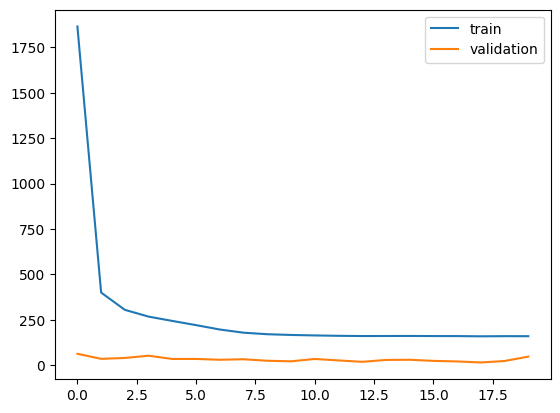

In [18]:
# define encoder
n_inputs = 5
visible = Input(shape=(5, 5))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

# fit the autoencoder model to reconstruct input
history = model.fit(train_data, train_data, epochs=20, batch_size=16, validation_data=(valid_data, valid_data))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()